# Generating CFPy-ready network structures with (1) pyKasso and (2) from general network information - PART I: Introduction

## 0. Note / Introduction: Network validation for CFPy
1. get a usable data-structure (from pyKasso or generated manually, should be a numpy array)
2. validate the network for CFPy
    1. check network structure:
        - in pyKasso it is assumed that diaginally adjacent nodes are **connected**; in MODFLOW-CFP, however, diagonally adjacent nodes are considered to be **not connected**
        - it is checked whether instances of \
        $ \left[ \begin{array}{rrrr} \ddots & & & \\ & 1 & 0 & \\ & 0 & 1 & \\ & & & \ddots \end{array} \right] $ or $ \left[ \begin{array}{rrrr} \ddots & & & \\ & 0 & 1 & \\ & 1 & 0 & \\ & & & \ddots \end{array} \right] $ \
        are present in the network (a $ 0 $ signals a matrix cell and a $ 1 $ signals a network node)
        - if such instances are present, they are altered by randomly adding an additional node in one of the possible positions, e.g., \
        $ \left[ \begin{array}{rrrr} \ddots & & & \\ & 1 & \color{red}{0} & \\ & 0 & 1 & \\ & & & \ddots \end{array} \right] \rightarrow \left[ \begin{array}{rrrr} \ddots & & & \\ & 1 & \color{red}{1} & \\ & 0 & 1 & \\ & & & \ddots \end{array} \right] $
    2. after checking, the resulting valid network is written to a text file
        - the data included in this file can be directly copied to the .nbr-file for further processing in CFPy
        
**Note:** the coupling between pyKasso and CFPy is still not ideal. While pyKasso can (at the moment) only calculate 2D network structures, CFPy can also process 3D network information. The 3D network information always consists of multiple 2D node planes, which are vertically connected at predefined points (in the .nbr-file, add a leading "c" to vertically connected nodes, e.g.: #plane1 ... c20.5 ...; # plane2 ...c10.5). If such connections should be considered at the moment, you need to work around manually. Even if multiple 2D networks are created with pyKasso, it can never be clear where they *really* are vertically connected.

**Note:** CFPy can only work with rectangular (2D models) / cuboid (3D models) data structures. If the model domain should later be different from a rectangle or cuboid, you still need to start from a rectangle / cuboid. Later, in the MODFLOW-model, you can set cells inactive to get your desired model domain. It is not yet tested if the network validation still works if a non-rectangular domain is used in pyKasso.

In [21]:
import CFPy as cfpy
import pykasso as pk
import matplotlib.pyplot as plt
import numpy as np

## 0.1 Show Versions

In [22]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [23]:
%watermark

Last updated: 2023-02-22T15:31:04.674831+01:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 4, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [24]:
%watermark --iversions

CFPy      : 0.1
matplotlib: 3.5.2
numpy     : 1.22.4
pykasso   : 0.1.0



## 1. Generating CFPy-ready network structures with pyKasso

In [25]:
# create a catchment from the information given in settings.yaml
catchment = pk.SKS(yaml_settings_file="settings.yaml")

CAUTION: You are using the development version of this package.


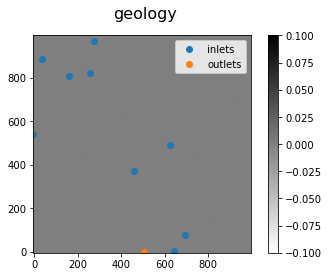

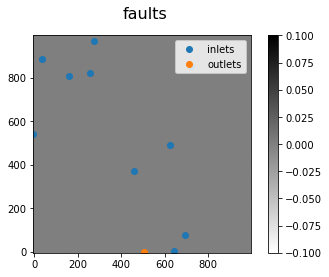

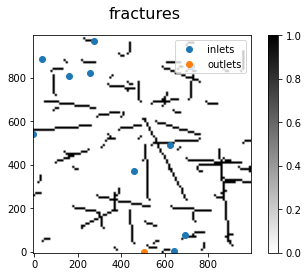

In [26]:
# get data for geology, faluts, and fractures as arrays
geology = catchment.get_geology()
faults = catchment.get_faults()
fractures = catchment.get_fractures()

# show maps of geology, faults, and fractures
catchment.show_catchment(data='geology')
catchment.show_catchment(data='faults')
catchment.show_catchment(data='fractures')


 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


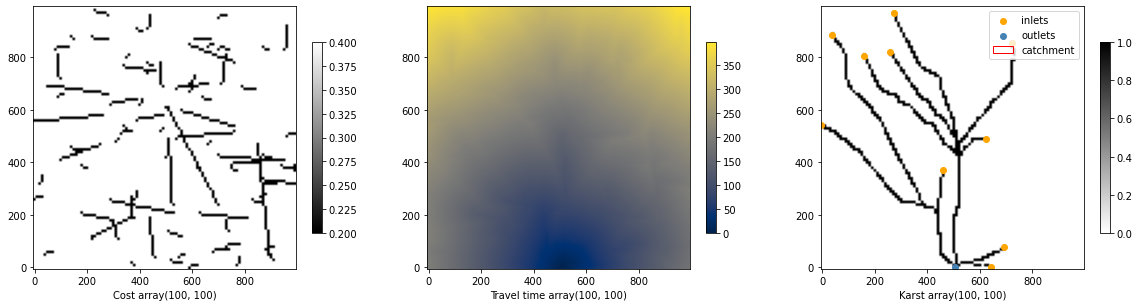

In [27]:
# compute karst networks from the given information
catchment.compute_karst_network()

# show the result of the last iteration (the last karst network)
# probability = True is not supported
catchment.show(probability=False)


Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.


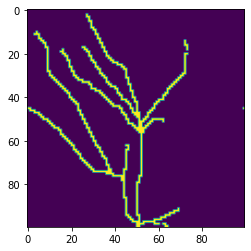

In [30]:
# generate elevation data (providing elevation data for the nodes is optional)
# NOTE: elevation data has to have the same shape as the node network array!
# here, a uniform elevation of 125.0 [L] is assumed for the node plane
elevs = np.ones_like(np.array(catchment.karst_simulations[-1].maps['karst'][-1])) * 125.

# validate the network from pyKasso
validator = cfpy.preprocessing.pyKassoValidator(network=catchment, elevations=elevs)
valid_network = validator.validate_network()

nrows = catchment.get_ynum()
ncols = catchment.get_xnum()

validator.generate_nbr(nrows=nrows, ncols=ncols, nlays=1, layer_elevations=[[1000.], [0.]])

# plot the network
plt.imshow(valid_network)

In [33]:
nbr = cfpy.nbr()
# read model layer/node and conduit layer/node elevations
# bot_elev has shape (n_layers, n_rows, n_cols)
# cond_elev has shape (n_conduit_layers, n_rows, n_cols)
# function looks for an .nbr-file, if none or more than one file is found, an error is raised
# make sure to only have one .nbr-file in the working directory
bot_elev, cond_elev = nbr.nbr_read()
# create nbr data
nbr_data = nbr.nbr(bot_elev, cond_elev)

Elapsed time (.nbr file read): 0.0 s
Elapsed time (write nbr data): 1.21 s
[1, 2, 3, 4, 5]


In [40]:
print(nbr_data[7][:5])

[[1, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0], [3, 2, 0, 0, 0, 0], [3, 4, 0, 0, 0, 0], [4, 5, 0, 0, 0, 0]]


In [ ]:
# export the network
# the exported information can directly be included in the .nbr-file as input for CFPy
# notes on how to use the generated data with CFPy is given at the end of the notebook
# per default, the network is exported to "CFPy_exported_network_for_NBR.txt" in the active directory
validator.export_network()

## 2. Generating CFPy-ready network structures from an existing array for a network structure

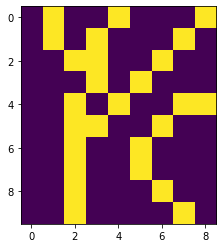

In [10]:
# an existing array for the node network structure
# 1 represents a node, 0 represents a matrix cell
a = np.array([[0., 1., 0., 0., 1., 0., 0., 0., 1.],
              [0., 1., 0., 1., 0., 0., 0., 1., 0.],
              [0., 0., 1., 1., 0., 0., 1., 0., 0.],
              [0., 0., 0., 1., 0., 1., 0., 0., 0.],
              [0., 0., 1., 0., 1., 0., 0., 1., 1.],
              [0., 0., 1., 1., 0., 0., 1., 0., 0.],
              [0., 0., 1., 0., 0., 1., 0., 0., 0.],
              [0., 0., 1., 0., 0., 1., 0., 0., 0.],
              [0., 0., 1., 0., 0., 0., 1., 0., 0.],
              [0., 0., 1., 0., 0., 0., 0., 1., 0.]])

# elevation data for the nodes
elev = np.ones((10, 9)) * 125.

# show the "raw" network, which has diagonally adjacent nodes
# the diagonally adjacent nodes will be handled by the validator
plt.imshow(a)


Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.


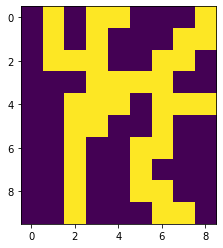

In [11]:
validator = cfpy.preprocessing.GeneralValidator(network=a, elevations=elev)
valid_network = validator.validate_network()
plt.imshow(valid_network)

In [12]:
# export the network
# the exported information can directly be included in the .nbr-file as input for CFPy
# notes on how to use the generated data with CFPy is given at the end of the notebook
validator.export_network()

## 3. Node network structure in CFPy

- **NOTE:** the .nbr-file can also be created automatically with the `generate_nbr` method of the `CFPy.preprocessing` module! The descriptions below help with creating the .nbr-file manually.
- CFPy gets most of the necessary data from a file (the .nbr-file) with a specific formatting (`[SPACE]` signals a space; do not include spaces elsewhere):
    - `LINE 0: N_rows [SPACE] N_cols`
    - `LINE 1: N_lays  [SPACEC] N_node_planes`
    - `LINE 2: # empty comment line`
    - `LINE 3:`
        - **either** `LINE 3: top_elev`, where `top_elev` is a single float specifying the uniform top elevation
        - **or** `LINE 3 to 3 + N_rows: top_elev` where `top_elev` is the cell-by-cell top elevations as floats (each line then represents one row in the MODFLOW model and values are separated in each line by `[SPACE]`, representing the values by column)
    - `LINE 4:`
        - repreat `LINE 3` and `LINE 4` for each layer; **ensure that all layer elevations are either given as floats or as cell-by-cell values!**
    - `LINE 5: # empty comment line`
    - `LINE 6:`
        - `LINE 6: node_network` where `node_network` are the cell-by-cell node elevations as floats (separated by `[SPACE]`), similar to the first option in `LINE 3`
        - **all node elevations need to be given as cell-by-cell values!**
        - **matrix cells have to be defined as `-999`**
        - **vertical connections between node planes have to be included by a leading "c" such as `c12.5`.** note that both cells, which are vertically connected, need (1) a leading "c" and (2) need to have the same (ROW, COL) locations (i.e., they only differ in the node elevation)
    - repeat `LINE 5` and `LINE 6` for each node plane
    
**Example**: \
`3 3` 3 rows, 3 columns\
`2 2` 2 MODFLOW layers, 2 node planes\
`#` \
`10.0 10.0 11.0` top layer elevation (row 1)\
`10.0 11.0 12.0` top layer elevation (row 2)\
`11.0 12.0 13.0` top layer elevation (row 3)\
`#` \
`5.0 5.0 5.0` layer boundary (between layer 1 and 2) elevation (row 1)\
`4.5 5.0 5.5` ...\
`4.0 4.5 5.0` ...\
`#` \
`0.0 0.0 0.0` bottom layer elevation (row 1)\
`0.5 1.0 1.5` ...\
`0.0 1.5 0.0` ...\
`#` \
`8.6 8.5 -999` node elevations for node plane 1 (row 1); **this block can be generated with pyKasso! after validating, the exported network information can directly be copied to the .nbr-file**\
`-999 c8.0 -999` ..., the "c" indicates a vertical connection\
`-999 7.3 -999` ...\
`#` \
`-999 -999 -999` node elevations for node plane 2 (row 1); **this block can also be generated with pyKasso**!\
`-999 c2.3 3.0` ...,the "c" indicates a vertical connection\
`2.5 2.6 -999` ...\

**See https://tu-dresden.de/bu/umwelt/hydro/igw/forschung/downloads/congen# for a more detailed documentation of the .nbr-file structure!**